<a href="https://colab.research.google.com/github/christopherdiamana/reinforcement-learning/blob/main/C1_TP_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

Etudiant·e : Christopher DIAMANA LUTETE

In [ ]:
! pip install matplotlib tqdm numpy ipympl opencv-python
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import math
import torch
import random
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(1)

K = 5 # num arms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Définition des vaccins

In [40]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
        """
        self.mean = p
        self.variance = p * (1. - p)

    def sample(self):
        return torch.rand(1) < self.mean
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.mean}' 

def generate_arms(num_arms: int):
    means = torch.rand(num_arms)
    MAB = [ArmBernoulli(m) for m in means]
    assert(MAB[0].mean == means[0])
    return MAB

MAB = generate_arms(K)

In [41]:
MAB

[<ArmBernoulli p=0.7576315999031067,
 <ArmBernoulli p=0.2793108820915222,
 <ArmBernoulli p=0.40306925773620605,
 <ArmBernoulli p=0.7346844673156738,
 <ArmBernoulli p=0.029281556606292725]

In [42]:
MAB[1].sample()

tensor([False])

In [43]:
MAB[1].mean

tensor(0.2793)

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. Pendant l'exploration, N patients reçoivent une dose d'un vaccin choisi aléatoirement.
2. Pendant l'exploitation, le vaccin procurant le meilleur taux d'immunisation est choisi pour les M patients suivants.

**1. Implémentez l'algorithme du médecin avec N = 50 et M = 500. Trouvez-vous le meilleur vaccin ? Quel regret obtenez-vous sur l'ensemble des patients ? Faites le test pour 10 valeurs moyennes de MAB**

In [44]:
N = 50
M = 500 

In [45]:
def medecin_exploration(patients: int):
  result = []
  for n in range(patients):
    idx = random.randrange(K)
    immunizated = MAB[idx].sample()
    #result.append(tuple((idx, immunizated)))
    result.append({'vaccine': idx, 'immunizated': immunizated})

  return result

In [46]:
res_exploration = medecin_exploration(N)

In [ ]:
res_exploration

In [59]:
def best_immunization(result: list):
  res_list = []
  for vaccine in range(K):
    #Ti = sum(1 for elem in result if elem.get('vaccine') == vaccine) #Le nombre de fois que le vaccin a été utilisé
    
    Ti = 0
    sub_sum = 0
    for patient in result:
      Xi = 1 if patient.get('vaccine') == vaccine else 0
      Rj = 1 if patient.get('immunizated') == True else 0
      Ti += Xi  #Le nombre de fois que le vaccin a été utilisé
      sub_sum += Xi * Rj

    Ri = ((1 / Ti) * sub_sum) if Ti > 0 else 0

    res_list.append({'vaccine': vaccine, 'rate': Ri})

    best = max(res_list, key=lambda x:x['rate'])

  return best


In [49]:
best_vaccine = best_immunization(res_exploration)

In [50]:
best_vaccine

{'rate': 0.7777777777777777, 'vaccine': 2}

In [51]:
def medecin_exploitation(patients: int, vaccin: int):
  result = []
  for idx in range(patients):
    immunizated = MAB[vaccin].sample()
    #result.append(tuple((idx, immunizated)))
    result.append(immunizated)

  return result

In [ ]:
res_exploitation = medecin_exploitation(M, best_vaccine.get('vaccine'))
res_exploitation

In [61]:
def regret_minimization(N_exploration_patients, M_exploitation_patients, exploration_result, exploitation_result):
  n = N_exploration_patients + M_exploitation_patients
  mu = max([ mab.mean for mab in MAB])
  recompense = 0
  for patient in exploration_result:
    recompense += 1 if patient.get('immunizated') else 0
  for res in exploitation_result:
    recompense += 1 if res else 0

  rn = n * mu - recompense
  return rn, recompense

In [62]:
regret, recompense = regret_minimization(N, M, res_exploration, res_exploitation)

In [63]:
regret

tensor(184.6974)

In [64]:
recompense

232

**2. Tracez le regret et la récompense de votre algorithme pour différentes valeurs de N allant de 5 à 400**

In [79]:
regrets_list = []
recompenses_list = []

for n_patients in range(5, 400):
  res_explor = medecin_exploration(n_patients)
  best_vacc = best_immunization(res_explor)
  res_exploit = medecin_exploitation(M, best_vacc.get('vaccine'))
  regr, recomp = regret_minimization(n_patients, M, res_explor, res_exploit)

  regrets_list.append(regr)
  recompenses_list.append(recomp)

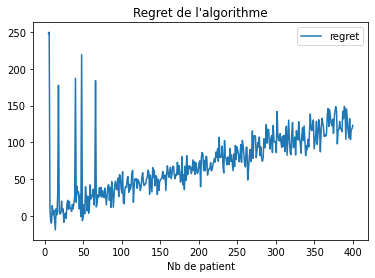

In [83]:
x = np.linspace(5, 400, 395)  # Sample data.

plt.plot(x, regrets_list, label='regret')  
plt.xlabel('Nb de patient')
plt.title("Regret de l'algorithme")
plt.legend()

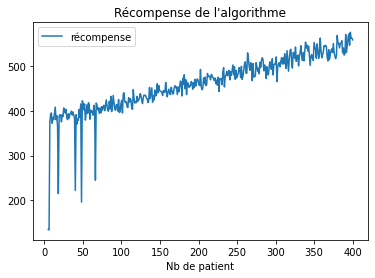

In [84]:
plt.plot(x, recompenses_list, label='récompense')  # etc.
plt.xlabel('Nb de patient')
plt.title("Récompense de l'algorithme")
plt.legend()

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Pour un modèle de manchot de Bernoulli (équivalent au problème étudié), la borne inférieure de Lai et Robbins [Lai et Robbins, 1985] stipule que :

$$\lim \inf_{T\rightarrow \infty} \frac{R_T}{\log T} \geq \sum_{a:\mu_a \lt \mu^*} \frac{\mu^∗−\mu_a}{kl(\mu_a, \mu^*)}  :=C(\mu)$$
 
 avec $kl(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ et  $R_T$ la récompense obtenue sur $T$ patients. En autres termes, cela signifie que la machine optimale est jouée exponentiellement plus souvent que les autres machines

In [ ]:
import math

In [ ]:
def c_mu(mba_vaccines):
  sum_result = 0
  mu_star = max([mab.mean for mab in mba_vaccines])

  for mba in mba_vaccines if mba.mean < mu_star :
    kl = mba.mean * math.log(mba.mean / mu_star) + (1 - mba.mean) * math.log((1 - mba.mean) / (1 - mu_star))
    sum_result +=  (mu_star - mba.mean) / kl



**3. Tracez cette borne au-dessus du graphique précédent**

## I.c. Upper Confidence Bounds

**4. Implémentez l'algorithme décrit en cours. Visualisez l'évolution de l'index de chaque machine à l'aide de Matplotlib.**

**5. Ajoutez un coefficient de votre choix devant le biais pour équilibrer exploration et exploitation et réduire le regret. Représentez sur un même graphique les performances d'UCB avec l'algorithme glouton et la borne inférieure**

# Echantillonnage de Thomson

**6. Implémentez l'algorithme. Visualisez chaque étape avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot)**

**7. Comparez son regret avec les graphiques précédents**

# Conclusion

**8. Comparez ce qu'il se passe avec un grand nombre de vaccins disponibles (K=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

# BONUS

Maintenant, on suppose que l'on peut proposer au patient un mélange des vaccins, c'est-à-dire que l'action choisie est donc une combinaison linéaire des vaccins.

**9. Implémenter l'algorithme Lin UCB tel que décrit dans ce document.**

https://www.yoanrussac.com/en/talk/talk1-ens/intro_linear_bandits.pdf